# Imports

In [1]:
import os
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

In [2]:
#reading the data sets
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

In [3]:
y_train,X_train = train["target"],train["text"]
y_validation,X_validation = validation["target"],validation ["text"]
y_test,X_test = test["target"],test["text"]

# Data Modelling

## Multinomial Naive Bias (tfidf tokenizer)

## The goal of using tfidf is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [4]:
# fitting and transforming X_train using a tfid vectorizer, ignoring terms with a document frequency lower than 3.
vect = TfidfVectorizer(min_df=3).fit(X_train)
X_train_vectorized = vect.transform(X_train)

In [5]:
# fitting training data to a multinomial NB model
model = sklearn.naive_bayes.MultinomialNB()
model_fit = model.fit(X_train_vectorized, y_train)

In [6]:
#looking at model features
feature_names = np.array(vect.get_feature_names())
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
((pd.Series(feature_names[sorted_tfidf_index[:20]]),
            pd.Series(feature_names[sorted_tfidf_index[-21:-1]])))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(0          indian
 1        gardener
 2           solve
 3      vegetables
 4      questioned
 5       neighbour
 6        dificult
 7         fightng
 8             3rd
 9             5th
 10            6th
 11            7th
 12    personality
 13        wonders
 14          moral
 15           sum1
 16       sweetest
 17       honeybee
 18        laughed
 19          havnt
 dtype: object,
 0          say
 1       unsold
 2      science
 3        those
 4         done
 5         babe
 6        thank
 7      towards
 8        space
 9          too
 10         out
 11          or
 12        okie
 13          ok
 14    anything
 15        wine
 16          of
 17     anytime
 18        nite
 19        type
 dtype: object)

In [7]:
#making predictions
predictions = model_fit.predict(vect.transform(X_test))
aucscore = roc_auc_score(y_test, predictions)
print(aucscore)

0.9060832821868656


In [8]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(pd.DataFrame(confusion_matrix(y_test, predictions),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))
print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print(f'True Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

             Predicted Spam  Predicted Ham
Actual Spam             717              1
Actual Ham               22             96

True Positives: 96
False Positives: 1
True Negatives: 717
False Negatives: 22
True Positive Rate: 0.8135593220338984
Specificity: 0.9986072423398329
False Positive Rate: 0.001392757660167131


## Support Vector Classifier Model 

In [9]:
#defining an additional function
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [10]:
#fit and transfor x_train and X_test
vectorizer = TfidfVectorizer(min_df=5)

X_train_transformed = vectorizer.fit_transform(X_train)
X_train_transformed_with_length = add_feature(X_train_transformed, X_train.str.len())

X_test_transformed = vectorizer.transform(X_test)
X_test_transformed_with_length = add_feature(X_test_transformed, X_test.str.len())

In [11]:
# SVM creation
clf = SVC(C=10000)

clf.fit(X_train_transformed_with_length, y_train)

SVC(C=10000)

In [12]:
y_predicted = clf.predict(X_test_transformed_with_length)


In [13]:
roc_auc_score(y_test, y_predicted)


0.9562343609839007

In [14]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
print(pd.DataFrame(confusion_matrix(y_test, y_predicted),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))
print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


print(f'True Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

             Predicted Spam  Predicted Ham
Actual Spam             716              2
Actual Ham               10            108

True Positives: 108
False Positives: 2
True Negatives: 716
False Negatives: 10
True Positive Rate: 0.9152542372881356
Specificity: 0.9972144846796658
False Positive Rate: 0.002785515320334262


## Logistic Regression Model with ngrams

In [15]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(min_df=5, ngram_range=[1,3])

X_train_transformed = vectorizer.fit_transform(X_train)
X_train_transformed_with_length = add_feature(X_train_transformed, [X_train.str.len(),
                                                                    X_train.apply(lambda x: len(''.join([a for a in x if a.isdigit()])))])

X_test_transformed = vectorizer.transform(X_test)
X_test_transformed_with_length = add_feature(X_test_transformed, [X_test.str.len(),
                                                                  X_test.apply(lambda x: len(''.join([a for a in x if a.isdigit()])))])

clf = LogisticRegression(C=100)

clf.fit(X_train_transformed_with_length, y_train)

y_predicted = clf.predict(X_test_transformed_with_length)

roc_auc_score(y_test, y_predicted)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.95414522449365

In [16]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
print(pd.DataFrame(confusion_matrix(y_test, y_predicted),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))
print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


print(f'\nTrue Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

             Predicted Spam  Predicted Ham
Actual Spam             713              5
Actual Ham               10            108

True Positives: 108
False Positives: 5
True Negatives: 713
False Negatives: 10

True Positive Rate: 0.9152542372881356
Specificity: 0.9930362116991643
False Positive Rate: 0.006963788300835654


# Model Comparison

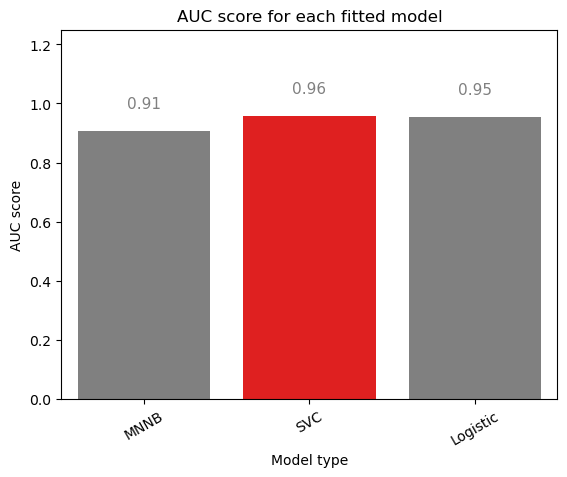

In [17]:
import seaborn as sb
import matplotlib.pyplot as plt

label = ['MNNB', 'SVC', 'Logistic']
auclist = [0.9060832821868656, 0.9562343609839007, 0.95414522449365]

#generates an array of length label and use it on the X-axis
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    clrs = ['grey' if (x < max(auclist)) else 'red' for x in auclist ]
    g=sb.barplot(x=index, y=auclist, palette=clrs) # color=clrs)   
    plt.xlabel('Model type', fontsize=10)
    plt.ylabel('AUC score', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('AUC score for each fitted model')
    ax=g
    for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
    g.set_ylim(0,1.25) #To make space for the annotations

plot_bar_x()

## Using a train-test split, the 3 models were put through the stages of X_train vectorization, model fitting on X_train and Y_train, make some predictions and generate the respective confusion matrices and area under the receiver operating characteristics curve for evaluation. (AUC-ROC)

## The resultant best performing model was the SVC Model, although it should be noted that all 3 models performed reasonably well at detecting spam messages (all AUC > 0.9)